# Рекомендация на основе коллаборативной системы

Для того, чтобы начать применять алгоритмы машинного обучения для составления рекомендаций, нужно составить матрицу предпочтений.

## Библиотеки

In [1]:
import pandas as pd
from sklearn.neighbors import NearestNeighbors
from utils import HM

## Загрузка данных

In [2]:
hm = HM()

articles = hm.get_articles(is_prepared=True)
customers = hm.get_customers()
sample_submission = hm.get_sample_submission()
transactions_train = hm.get_transactions_train()

## Составление матрицы предпочтений на основе предмета рекомендации

Из `transactions_train` вытащим последние покупки для каждого клиента для предсказание будущих закупок, а остальные данные используем для построения матрицы предпочтений.

### Разделение `transactions_train`

In [3]:
transactions_train['t_dat'] = pd.to_datetime(transactions_train['t_dat'])

In [4]:
# last_transactions = transactions_train.groupby('customer_id').apply(lambda x: x.sort_values(by='t_dat', ascending=False).iloc[0])
# last_transactions[['t_dat', 'article_id', 'price', 'sales_channel_id']].to_csv('./data_prepared/last_transactions.csv')

In [5]:
last_transactions = pd.read_csv('./data_prepared/last_transactions.csv')

In [6]:
last_transactions['t_dat'] = pd.to_datetime(last_transactions['t_dat'])

In [7]:
last_transactions = last_transactions.set_index('customer_id')

In [8]:
# Удалим последние покупки клиентов
# Способо удаления взят от сюда https://clck.ru/335orn

# transactions = transactions_train.merge(last_transactions, on=last_transactions.columns.tolist(), how='outer', indicator=True)\
#    .query("_merge != 'both'")\
#    .drop('_merge', axis=1)\
#    .reset_index(drop=True)
#transactions.set_index('customer_id').to_csv('./data_prepared/transactions.csv')

In [9]:
transactions = pd.read_csv('./data_prepared/transactions.csv')

### Состалвение матрицы предпочтений

Так как `pivot_table` - затратный метод, отсортируем все транзакции по рейтингу товара и возьмем выборку самых популярных

In [10]:
transactions_with_rating = transactions.merge(articles[['article_id', 'rating']], on='article_id', how='left')

In [11]:
transactions_with_rating = transactions_with_rating.sort_values(by='rating', ascending=False)

In [12]:
preference_matrix = pd.pivot_table(transactions_with_rating[:1_000_000], index=["article_id"], values='t_dat', columns='customer_id', aggfunc=len)

In [13]:
preference_matrix = preference_matrix.fillna(0)

In [14]:
preference_matrix.columns = range(preference_matrix.shape[1])

## Обучение модели

In [15]:
knn = NearestNeighbors(metric='cosine', n_neighbors=20, n_jobs=-1)
knn.fit(preference_matrix)

NearestNeighbors(metric='cosine', n_jobs=-1, n_neighbors=20)

## Составление рекомендаций

In [16]:
count_pred = 13
top_rating_articles = ' '.join(articles[:count_pred]['article_id'].map(lambda x: '0' + str(x)))

In [17]:
predict_for = sample_submission['customer_id'].tolist()
sample_submission = sample_submission.set_index('customer_id')

In [ ]:
import os

clear = lambda: os.system('cls')

counter = {
    'not in': 0,
    'in': 0
}

for i in range(len(predict_for)):
    customer = predict_for[i]
    
    if customer not in last_transactions.index:
        sample_submission.loc[customer, 'prediction'] = top_rating_articles
        counter['not in'] += 1
        continue
    
    prev_article = last_transactions.loc[customer]['article_id']
    
    if prev_article not in preference_matrix.index:
        sample_submission.loc[customer, 'prediction'] = top_rating_articles
        counter['not in'] += 1
        continue
    
    distances, indices = knn.kneighbors([preference_matrix.loc[prev_article].tolist()], n_neighbors=count_pred+1)
    
    articles = list()
    
    for idx in indices[0]:
        articles.append(preference_matrix.iloc[idx].name)
    
    sample_submission.loc[customer, 'prediction'] = ' '.join(map(lambda x: '0' + str(x), articles[1:]))
    counter['in'] += 1

## Вывод
Ужасный подход к реализации концепнии коллаборативной рекомендации. А также опять плохой результат. Пора начать вдохновляться чужими решениями.

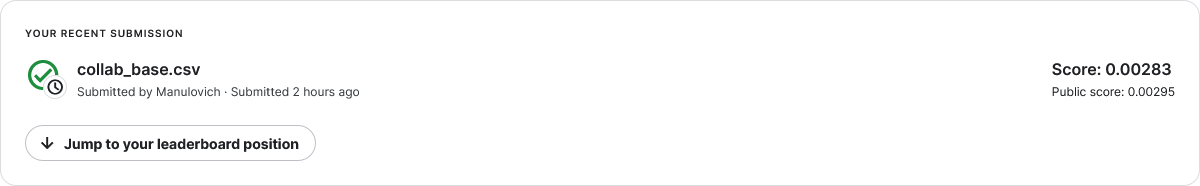